### Modeling Basketball Scores

The goal of this notebook is to create a model that can predict the scores of basketball games given each teams' offensive and defensive abilities and home advantage. In the future, I hope to also incorporate other factors such as

1. Individual players offensive and defensive abilities
2. Number of days of rest since last game
3. Distance traveled since last game

### Model Description

In this notebook, I use two types of models that I call the multiplicative model and the additive model. The names are based on how the parameters are combined to predict scores. Given the following definitions:

Home team offensive parameter: $x_1$ <br>
Home team defensive parameter: $y_1$ <br>
Away team offensive parameter: $x_2$ <br>
Away team defensive parameter: $y_2$ <br>
Home advantage parameter: $h$

the predicted points scored by the home and away teams will be

**Multiplicative model**<br>
Home points = $x_1  y_2  (1+h)$ <br>
Away points = $x_2  y_1 (1-h)$ <br>

**Additive model**<br>
Home points = $x_1 + y_2 + h$ <br>
Away points = $x_2 + y_1 - h$

If a game is played at a neutral venue, then $h$ is removed from each equation.

In the event that a game goes to one or more overtime periods, the prediction is multiplied by $\left(1 + \frac{5N_{OT}}{t_{reg}} \right)$ where $N_{OT}$ is the number of overtimes and $t_{reg}$ is the length of a regulation game. In the derivation below, I will represent this expression as simply $t[i]$.

Both models are relatively simple. As will be shown below, they can do a solid job of predicting which teams will rise to the top or sink to the bottom after playing many games, but it does not account for the factors that lead to game-to-game variability. To some extent, that variability cannot be modeled because player performance can change unpredictably, but I do think that a model that accounts for factors like individual player strengths, rest, and travel could outperform the simpler models presented here.

### Fitting the Models

We are given data in which some number of teams played $N$ games against one another. Assuming that the points are distributed according to a covariate Gaussian distribution (with covariance), the total probability of all the game results is given by

$$
P \propto \prod_{i=1}^{N}{exp\left(\frac{-\sigma^2(n_h[i]-f_h[i])^2-\sigma^2(n_a[i]-f_a[i])^2+2\sigma_{ha}(n_h[i]-f_h[i])(n_a[i]-f_a[i])}{2(\sigma^4-\sigma_{ha}^2)}\right)}
$$

where the variables mean the following: 

$n_h[i]$: Points scored by the home team in game $i$. <br>
$n_a[i]$: Points scored by the away team in game $i$. <br>
$T_h[i]$: ID of home team in game $i$. <br>
$T_a[i]$: ID of away team in game $i$. <br>
$x[T_h[i]]$: Offensive parameter for home team of game $i$. Switch $T_h$ to $T_a$ for away team. <br>
$y[T_h[i]]$: Defensive parameter for home team of game $i$. Switch $T_h$ to $T_a$ for away team. <br>
$h$: Home advantage parameter. <br>
$f_h[i]$: Shorthand for $f_h(x[T_h[i]],y[T_a[i]],h, t[i])$ which represents a function that calculates the home team's predicted points in game $i$. I also use $f_a[i]$ to represent the away team's predicted points in game $i$. The functions $f_h$ and $f_a$ are placeholders that can be replaced with the multiplicative model, the additive model, or a more complex model that could potentially account for more features. <br>
$\sigma^2$: The variance of the points scored by a team in any given game. I am assuming that this is constant. <br>
$\sigma_{ha}$: The covariance between points scored by the home team and points scored by the away team. <br>

Finding the MLE parameters means finding values of $x$ and $y$ for each team and $h$ that maximize $P$. However, it will be way easier to do the calculus if I maximize $ln(P)$ instead because it turns a product of many terms into a sum.

$$
ln(P) \propto \sum_{i=1}^{N}{-\sigma^2(n_h[i]-f_h[i])^2-\sigma^2(n_a[i]-f_a[i])^2+2\sigma_{ha}(n_h[i]-f_h[i])(n_a[i]-f_a[i])}
$$

Note that the denominator has been removed because it is a constant and does not matter once a derivative is taken. Hypothetically, to find the correct values of each parameter, I need to take the derivative of $ln(P)$ with respect to each of those parameters, but one example will suffice. If I take the derivative of $ln(P)$ with respect to the offensive parameter for team $k$, we get

$$
\frac{dln(P)}{dx[k]} \propto \sum_{k=T_h[i]}^{N}{\sigma^2(n_h[i]-f_h[i])\frac{df_h[i]}{dx[k]}} + \sum_{k=T_a[i]}^{N}{\sigma^2(n_a[i]-f_a[i])\frac{df_a[i]}{dx[k]}} - \sum_{k=T_h[i]}^{N}{\sigma_{ha}(n_a[i]-f_a[i])\frac{df_h[i]}{dx[k]}} - \sum_{k=T_a[i]}^{N}{\sigma_{ha}(n_h[i]-f_h[i])\frac{df_a[i]}{dx[k]}}
$$

Setting this expression to 0 and rearranging results in the following equation:

$$
\sum_{k=T_h[i]}^{N}{(\sigma^2n_h[i]-\sigma_{ha}n_a[i])\frac{df_h[i]}{dx[k]}} + \sum_{k=T_a[i]}^{N}{(\sigma^2n_a[i]-\sigma_{ha}n_h[i])\frac{df_a[i]}{dx[k]}} = \sum_{k=T_h[i]}^{N}{(\sigma^2f_h[i]-\sigma_{ha}f_a[i])\frac{df_h[i]}{dx[k]}} + \sum_{k=T_a[i]}^{N}{(\sigma^2f_a[i]-\sigma_{ha}f_h[i])\frac{df_a[i]}{dx[k]}}
$$

While this equation still looks pretty complicated, it has a nice symmetry. The left and right sides of the equation are identical except the left has the actual points scored, $n_h$ and $n_a$, while the right side has the predicted points, $f_h$ and $f_a$. If we replace the $f$ functions with the additive model and ignore the covariance, it becomes much easier to intepret:

$$
\sum_{k=T_h[i]}^{N}{t[i]n_h[i]} + \sum_{k=T_a[i]}^{N}{t[i]n_a[i]} = \sum_{k=T_h[i]}^{N}{t[i]^2(x[k]+y[T_a[i]]+h)} + \sum_{k=T_a[i]}^{N}{t[i]^2(x[k]+y[T_h[i]]-h)}
$$

The left side of the equation is now just the total points scored by team $k$ and the right side is the total points the model predicts team $k$ will score, though each game is weighted by the length of the game. If the offensive parameters, $x$, are adjusted so that the predicted weighted points scored exactly match the actual weighted points scored for each team, then we have the MLE parameters for the model. We could go through nearly the same derivation to show that the defensive parameters, $y$, should be adjusted so that the predicted weighted points allowed exactly match the actual weighted points allowed for each team.

**Finding parameters iteratively**

The main benefit of the derivation above is that it hints at an alternative to minimizing the RMSE for fitting the parameters. To see how this method works, imagine we have some estimates for $x$ and $y$ for each team plus the home advantage parameter. If a specific team scored 5,000 total points throughout a 50-game season, but the model predicts that it would only score 4,500 in those games, we can simply add 500/50 to that team's offensive parameter so the prediction exactly matches the real value (this assumes no overtimes, but the denominator can be adjusted to account for overtimes played). This can be done for every team so that they all have the correct prediction for total points scored. The same can be done with the defensive parameters by matching the points allowed by each team. By alternating between adjusting offensive and defensive parameters, both will converge to the MLE values. The home advantage parameter can be fit by matching the total home points minus the total away points.

This technique tends to converge very quickly, especially if the values are initialized to reasonable values. The values converge in fewer than 10 iterations when running this algorithm on a full season of NBA games.

**Multiplicative Model**

Above, we saw that the additive model can be fit by just matching the weighted points scored and allowed for each team. Hypothetically, we could do the same thing with the multiplicative model by just weighting all points based on the length of each game, but the actual MLE solution is a little more complicated. If we once again ignore covariance between home and away points, but we substitute the multiplicative model for $f_h$ and $f_a$, the result is

$$
\sum_{k=T_h[i]}^{N}{y[T_a[i]](1+h)t[i]n_h[i]} + \sum_{k=T_a[i]}^{N}{y[T_h[i]](1-h)t[i]n_a[i]} = \sum_{k=T_h[i]}^{N}{y[T_a[i]]^2(1+h)^2t[i]^2x[k]} + \sum_{k=T_a[i]}^{N}{y[T_h[i]]^2(1-h)^2t[i]^2m[k]}
$$

The left side still corresponds to actual points scored and the right hand side still corresponds to predicted points, but the weights are a bit more complicated. The iterative method described above will still work, but instead of adding some amount to each parameter, we multiply. If a team's weights points equals $N_w$, but the model predicts they would accumulate $N_m$ weighted points in the same games, that team's offensive parameter should be multiplied by $\frac{N_w}{N_m}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
games = pd.read_excel('NCAA2223.xlsx')
#games = pd.read_excel('games.xlsx')
games

,date,away_team,away_score,home_score,home_team,ot,neutral
0,2022-11-07,UNC Wilmington,56,69,North Carolina,NaN,NaN
1,2022-11-07,North Florida,63,104,Gonzaga,NaN,NaN
2,2022-11-07,Northern Colorado,36,83,Houston,NaN,NaN
3,2022-11-07,Howard,63,95,Kentucky,NaN,NaN
4,2022-11-07,Mississippi Valley State,53,117,Baylor,NaN,NaN
...,...,...,...,...,...,...,...
5597,2023-03-12,Yale,65,74,Princeton,NaN,NaN
5598,2023-03-12,Texas A&M,63,82,Alabama,NaN,N
5599,2023-03-12,Dayton,56,68,VCU,NaN,N
5600,2023-03-12,Memphis,75,65,Houston,NaN,N


In [3]:
# Change ot column to count number of overtimes (for NBA)
games['ot'].replace({pd.NA:0, "OT":1, "2OT":2, "3OT":3, "4OT":4, "5OT":5, "6OT":6}, inplace=True)

In [3]:
# Replace NaN in ot column with 0 (if college)
games['ot'].replace({pd.NA: 0}, inplace=True)

In [8]:
# Change neutral column to be 1 if neutral, 0 otherwise
games['neutral'] = games['neutral'].apply(lambda x: 0 if pd.isna(x) else 1)

In [10]:
games

,date,away_team,away_score,home_score,home_team,ot,neutral
0,2022-11-07,UNC Wilmington,56,69,North Carolina,0.0,0
1,2022-11-07,North Florida,63,104,Gonzaga,0.0,0
2,2022-11-07,Northern Colorado,36,83,Houston,0.0,0
3,2022-11-07,Howard,63,95,Kentucky,0.0,0
4,2022-11-07,Mississippi Valley State,53,117,Baylor,0.0,0
...,...,...,...,...,...,...,...
5597,2023-03-12,Yale,65,74,Princeton,0.0,0
5598,2023-03-12,Texas A&M,63,82,Alabama,0.0,1
5599,2023-03-12,Dayton,56,68,VCU,0.0,1
5600,2023-03-12,Memphis,75,65,Houston,0.0,1


In [12]:
# Function for fitting parameters for offense, defense, and home advantage.
def fit_parameters(game_data,
                   column_names=['home_team','home_score','away_score','away_team','ot','neutral'],
                   model_type='mult',
                   reg_time=48,
                   ot_time=5,
                   no_neutral=True,
                   delta_thresh=1e-5):
    """
    This function takes in scores of games and calculates parameters for offense,
    defense, and home advantage iteratively.
    
    Input:
    game_data: A Pandas DataFrame that contains columns representing teams, scores,
    whether or not the game was played at a neutral location, and the number of overtimes.
    
    column_names: Defines the names of the columns that correspond to each necessary feature.
    The default column_names are:
        home_team: Home team. Can be name or numerical identifier.
        home_score: Score for home team.
        away_score: Score for away team.
        away_team: Away team. Can be name or numerical identifier.
        ot: Number of overtimes played.
        neutral: 1 if the game was played at a neutral location. 0 if not.
    The DataFrame can contain other columns and the order does not matter.
    
    model_type: Type of model to use. Options are:
        mult: Multiplicative model that calculates home score as
            (home offense)*(away defense)*(1+home advantage)
            and calculates away score as
            (away offense)*(home defense)*(1-home advantage)
        add: Additive model that calculates home score as
            (home offense) + (away defense) + (home advantage)
            and calculates away score as
            (away offense) + (home defense) - (home advantage)
            
        If any overtime was played, the prediction gets scaled up to account for that.
    
    reg_time: Number of minutes in a regulation game. Default is 48 (NBA length).
    
    ot_time: Number of minutes in an overtime. Default is 5.
    
    no_neutral: Specifies if none of the gamees were at a neutral location. Default is True.
    
    delta_thresh: In order for the iterative fitting of parameters to stop, all changes must
    be below the delta_thresh. Default is 1e-5.
    
    Output:
    1. A DataFrame containing the offense and defense parameters for the model
    2. Home advantage parameter
    3. Copy of the input DataFrame that now contains predicted scores.
    """
    # Make copy of games_data DataFrame
    game_copy = game_data.copy()
    
    # Get the necessary column names
    h_team, h_score, a_score, a_team, ot, neutral = column_names
    
    # Define names that will be used often for other columns and will appear in output DataFrame
    h_id = 'home_id'
    a_id = 'away_id'
    h_mod = h_score+'_mod'
    a_mod = a_score+'_mod'
    wh_score = 'weighted_home_score'
    wa_score = 'weighted_away_score'
    wh_mod = 'weighted_home_score_mod'
    wa_mod = 'weighted_away_score_mod'
    time = 'time'
    
    # Create column that represents duration of game
    game_copy[time] = (1 + ot_time*game_copy[ot]/reg_time)
    
    # Change neutral column so that it is 1 if neutral, 0 if not
    if no_neutral == False:
        game_copy[neutral] = [1 if neut==1 else 0 for neut in game_copy[neutral]]
    
    # Get list of unique teams
    teams = np.sort(game_copy[h_team].unique())
    
    # Turn team names into numerical IDs
    team_dict = {team: num for num, team in enumerate(teams)}
    game_copy[h_id] = game_copy[h_team].replace(team_dict)
    game_copy[a_id] = game_copy[a_team].replace(team_dict)
            
    # Multiplicative model
    if model_type == 'mult':
        # Initialize the parameters
        off_par = np.sqrt(len(teams)*[game_copy[h_score].mean()/2 + game_copy[a_score].mean()/2])
        
        def_par = off_par
        
        h_adv = 0.0
        
        end_loop = 0
        # Create variable to track which parameter is changing
        off_def_adv = 0
        while end_loop < 3:
            # Use model to calculate scores for each game
            if no_neutral:
                game_copy[a_mod] = off_par[game_copy[a_id]] * def_par[game_copy[h_id]] * (1 - h_adv) * game_copy[time]
                game_copy[h_mod] = off_par[game_copy[h_id]] * def_par[game_copy[a_id]] * (1 + h_adv) * game_copy[time]
            else:
                game_copy[a_mod] = off_par[game_copy[a_id]] * def_par[game_copy[h_id]] * \
                (1 - h_adv*(1-game_copy[neutral])) * game_copy[time]
                game_copy[h_mod] = off_par[game_copy[h_id]] * def_par[game_copy[a_id]] * \
                (1 + h_adv*(1-game_copy[neutral])) * game_copy[time]
                
            # Adjust offensive parameters
            if off_def_adv == 0:
                if no_neutral:
                    # Actual points
                    game_copy[wa_score] = game_copy[a_score] * def_par[game_copy[h_id]] * (1 - h_adv) * game_copy[time]
                    game_copy[wh_score] = game_copy[h_score] * def_par[game_copy[a_id]] * (1 + h_adv) * game_copy[time]
                    # Predicted points
                    game_copy[wa_mod] = game_copy[a_mod] * def_par[game_copy[h_id]] * (1 - h_adv) * game_copy[time]
                    game_copy[wh_mod] = game_copy[h_mod] * def_par[game_copy[a_id]] * (1 + h_adv) * game_copy[time]                  
                else:
                    # Actual points
                    game_copy[wa_score] = game_copy[a_score] * def_par[game_copy[h_id]] * \
                    (1 - h_adv*(1-game_copy[neutral])) * game_copy[time]
                    game_copy[wh_score] = game_copy[h_score] * def_par[game_copy[a_id]] * \
                    (1 + h_adv*(1-game_copy[neutral])) * game_copy[time]
                    # Predicted points
                    game_copy[wa_mod] = game_copy[a_mod] * def_par[game_copy[h_id]] * \
                    (1 - h_adv*(1-game_copy[neutral])) * game_copy[time]
                    game_copy[wh_mod] = game_copy[h_mod] * def_par[game_copy[a_id]] * \
                    (1 + h_adv*(1-game_copy[neutral])) * game_copy[time]
                    
                # Calculate points scored by each team
                # Actual points
                w_pts_scored = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wa_score]) + \
                                         np.sum(game_copy.loc[game_copy[h_id]==t_id,wh_score]) \
                                         for t_id in team_dict.values()])
                # Predicted points
                w_pts_scored_m = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wa_mod]) + \
                                           np.sum(game_copy.loc[game_copy[h_id]==t_id,wh_mod]) \
                                           for t_id in team_dict.values()])
                
                # Save old parameter values
                off_par_old = off_par
                
                # Rescale offensive parameters
                off_par = off_par * w_pts_scored / w_pts_scored_m
                
                # Check if changes are within threshold
                if np.max(np.abs(off_par - off_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust defensive parameters
            if off_def_adv == 1:
                if no_neutral:
                    # Actual points
                    game_copy[wa_score] = game_copy[a_score] * off_par[game_copy[a_id]] * (1 - h_adv) * game_copy[time]
                    game_copy[wh_score] = game_copy[h_score] * off_par[game_copy[h_id]] * (1 + h_adv) * game_copy[time]
                    # Predicted points
                    game_copy[wa_mod] = game_copy[a_mod] * off_par[game_copy[a_id]] * (1 - h_adv) * game_copy[time]
                    game_copy[wh_mod] = game_copy[h_mod] * off_par[game_copy[h_id]] * (1 + h_adv) * game_copy[time]                  
                else:
                    # Actual points
                    game_copy[wa_score] = game_copy[a_score] * off_par[game_copy[a_id]] * \
                    (1 - h_adv*(1-game_copy[neutral])) * game_copy[time]
                    game_copy[wh_score] = game_copy[h_score] * off_par[game_copy[h_id]] * \
                    (1 + h_adv*(1-game_copy[neutral])) * game_copy[time]
                    # Predicted points
                    game_copy[wa_mod] = game_copy[a_mod] * off_par[game_copy[a_id]] * \
                    (1 - h_adv*(1-game_copy[neutral])) * game_copy[time]
                    game_copy[wh_mod] = game_copy[h_mod] * off_par[game_copy[h_id]] * \
                    (1 + h_adv*(1-game_copy[neutral])) * game_copy[time]
                    
                # Calculate points scored by each team
                # Actual points
                w_pts_allowed = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wh_score]) + \
                                         np.sum(game_copy.loc[game_copy[h_id]==t_id,wa_score]) \
                                         for t_id in team_dict.values()])
                # Predicted points
                w_pts_allowed_m = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wh_mod]) + \
                                           np.sum(game_copy.loc[game_copy[h_id]==t_id,wa_mod]) \
                                           for t_id in team_dict.values()])
                
                # Save old parameter values
                def_par_old = def_par
                
                # Rescale offensive parameters
                def_par = def_par * w_pts_allowed / w_pts_allowed_m
                
                # Check if changes are within threshold
                if np.max(np.abs(def_par - def_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust home advantage parameter
            if off_def_adv == 2:
                # Calculate total home and away points
                if no_neutral:
                    # Actual minus no h_adv predicted
                    game_copy[wa_score] = (game_copy[a_score] - game_copy[a_mod]/(1 - h_adv)) * \
                    off_par[game_copy[a_id]] * def_par[game_copy[h_id]] * game_copy[time]
                    game_copy[wh_score] = (game_copy[h_score] - game_copy[h_mod]/(1 + h_adv)) * \
                    off_par[game_copy[h_id]] * def_par[game_copy[a_id]] * game_copy[time]
                    # Predicted points without h_adv
                    game_copy[wa_mod] = game_copy[a_mod]**2 / (1 - h_adv)**2
                    game_copy[wh_mod] = game_copy[h_mod]**2 / (1 + h_adv)**2
                else:
                    # Actual minus no h_adv predicted
                    game_copy[wa_score] = (game_copy[a_score] - game_copy[a_mod]/(1 - h_adv*(1-game_copy[neutral]))) * \
                    off_par[game_copy[a_id]] * def_par[game_copy[h_id]] * game_copy[time]
                    game_copy[wh_score] = (game_copy[h_score] - game_copy[h_mod]/(1 + h_adv*(1-game_copy[neutral]))) * \
                    off_par[game_copy[h_id]] * def_par[game_copy[a_id]] * game_copy[time]
                    # Predicted points without h_adv
                    game_copy[wa_mod] = game_copy[a_mod]**2 / (1 - h_adv*(1-game_copy[neutral]))**2
                    game_copy[wh_mod] = game_copy[h_mod]**2 / (1 + h_adv*(1-game_copy[neutral]))**2
                    
                # Sum non-neutral games
                if no_neutral:
                    wh_pts = np.sum(game_copy[wh_score])
                    wa_pts = np.sum(game_copy[wa_score])
                    wh_pts_m = np.sum(game_copy[wh_mod])
                    wa_pts_m = np.sum(game_copy[wa_mod])
                else:
                    wh_pts = np.sum(game_copy.loc[game_copy[neutral]==0,wh_score])
                    wa_pts = np.sum(game_copy.loc[game_copy[neutral]==0,wa_score])
                    wh_pts_m = np.sum(game_copy.loc[game_copy[neutral]==0,wh_mod])
                    wa_pts_m = np.sum(game_copy.loc[game_copy[neutral]==0,wa_mod])

                # Save old parameter value
                h_adv_old = h_adv
            
                # Rescale home advantage parameter
                h_adv = (wh_pts - wa_pts) / (wh_pts_m + wa_pts_m)
                
                # Check if changes are within threshold
                if np.abs(h_adv - h_adv_old) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Increment off_def_adv
            off_def_adv = (off_def_adv + 1) % 3
        
    # Additive model
    if model_type == 'add':
        # Initialize the parameters
        off_par = np.array(len(teams)*[game_copy[h_score].mean()/2 + game_copy[a_score].mean()/2])/2
        
        def_par = off_par
        
        h_adv = 0.0
        
        end_loop = 0
        # Create variable to track which parameter is changing
        off_def_adv = 0
        while end_loop < 3:
            # Use model to predict scores for each game
            if no_neutral:
                game_copy[a_mod] = (off_par[game_copy[a_id]] + def_par[game_copy[h_id]] - h_adv) * game_copy[time]
                game_copy[h_mod] = (off_par[game_copy[h_id]] + def_par[game_copy[a_id]] + h_adv) * game_copy[time]
            else:
                game_copy[a_mod] = (off_par[game_copy[a_id]] + def_par[game_copy[h_id]] - h_adv*(1-game_copy[neutral])) * \
                game_copy[time]
                game_copy[h_mod] = (off_par[game_copy[h_id]] + def_par[game_copy[a_id]] + h_adv*(1-game_copy[neutral])) * \
                game_copy[time]
                
            # Adjust offensive parameters
            if off_def_adv == 0:
                # Calculate weighted points
                # Actual points
                game_copy[wa_score] = game_copy[a_score] * game_copy[time]
                game_copy[wh_score] = game_copy[h_score] * game_copy[time]
                # Predicted points
                game_copy[wa_mod] = game_copy[a_mod] * game_copy[time]
                game_copy[wh_mod] = game_copy[h_mod] * game_copy[time]

                # Calculate weighted points per team
                # Actual points
                w_pts_scored = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wa_score]) + \
                                         np.sum(game_copy.loc[game_copy[h_id]==t_id,wh_score]) \
                                         for t_id in team_dict.values()])
                # Predicted points
                w_pts_scored_m = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wa_mod]) + \
                                           np.sum(game_copy.loc[game_copy[h_id]==t_id,wh_mod]) \
                                           for t_id in team_dict.values()])
                
                # Calculate time played by each team
                t_team = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,time]) + \
                                   np.sum(game_copy.loc[game_copy[h_id]==t_id,time]) \
                                   for t_id in team_dict.values()])
                
                # Save old parameter values
                off_par_old = off_par
                
                # Rescale offensive parameters
                off_par = off_par + (w_pts_scored - w_pts_scored_m)/t_team
                
                # Check if changes are within threshold
                if np.max(np.abs(off_par - off_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust defensive parameters
            if off_def_adv == 1:
                # Calculate weighted points
                # Actual points
                game_copy[wa_score] = game_copy[a_score] * game_copy[time]
                game_copy[wh_score] = game_copy[h_score] * game_copy[time]
                # Predicted points
                game_copy[wa_mod] = game_copy[a_mod] * game_copy[time]
                game_copy[wh_mod] = game_copy[h_mod] * game_copy[time]

                # Calculate weighted points per team
                # Actual points
                w_pts_allowed = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wh_score]) + \
                                          np.sum(game_copy.loc[game_copy[h_id]==t_id,wa_score]) \
                                          for t_id in team_dict.values()])
                # Predicted points
                w_pts_allowed_m = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,wh_mod]) + \
                                            np.sum(game_copy.loc[game_copy[h_id]==t_id,wa_mod]) \
                                            for t_id in team_dict.values()])
                
                # Calculate time played by each team
                t_team = np.array([np.sum(game_copy.loc[game_copy[a_id]==t_id,time]) + \
                                   np.sum(game_copy.loc[game_copy[h_id]==t_id,time]) \
                                   for t_id in team_dict.values()])
                
                # Save old parameter values
                def_par_old = def_par
                
                # Rescale defensive parameters
                def_par = def_par + (w_pts_allowed - w_pts_allowed_m)/t_team
                
                # Check if changes are within threshold
                if np.max(np.abs(def_par - def_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Adjust home advantage parameter
            if off_def_adv == 2:
                # Calculate total weighted points
                if no_neutral:
                    # Actual
                    home_total = np.sum(game_copy[h_score] * game_copy[time])
                    away_total = np.sum(game_copy[a_score] * game_copy[time])
                    # Predicted
                    home_total_m = np.sum(game_copy[h_mod] * game_copy[time])
                    away_total_m = np.sum(game_copy[a_mod] * game_copy[time])
                    # Total time
                    time_total = np.sum(game_copy[time])
                else:
                    # Actual
                    home_total = np.sum(game_copy.loc[game_copy[neutral]==0,h_score] * \
                                        game_copy.loc[game_copy[neutral]==0,time])
                    away_total = np.sum(game_copy.loc[game_copy[neutral]==0,a_score] * \
                                        game_copy.loc[game_copy[neutral]==0,time])
                    # Predicted 
                    home_total_m = np.sum(game_copy.loc[game_copy[neutral]==0,h_mod] * \
                                          game_copy.loc[game_copy[neutral]==0,time])
                    away_total_m = np.sum(game_copy.loc[game_copy[neutral]==0,a_mod] * \
                                          game_copy.loc[game_copy[neutral]==0,time])
                    # Total time of non-neutral games
                    time_total = np.sum(game_copy.loc[game_copy[neutral]==0,time])
                    
                # Save old parameter value
                h_adv_old = h_adv
            
                # Rescale home advantage parameter
                h_adv = h_adv + (home_total - away_total - home_total_m + away_total_m) / 2 / time_total
                
                # Check if changes are within threshold
                if np.abs(h_adv - h_adv_old) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                
            # Increment off_def_adv
            off_def_adv = (off_def_adv + 1) % 3
        
    return pd.DataFrame(data={'team':teams,'offense':off_par,'defense':def_par}), h_adv, game_copy

In [13]:
def fit_parameters_correl(game_data,
                          column_names=['home_team','home_score','away_score','away_team','ot','neutral'],
                          model_type='mult',
                          reg_time=48,
                          ot_time=5,
                          no_neutral=True,
                          delta_thresh=1e-5):
    """
    This function takes in scores of games and calculates parameters for offense,
    defense, and home advantage iteratively.
    
    This function differs from fit_parameters by taking into account correlation
    between the points scored by each team.
    
    Input:
    game_data: A Pandas DataFrame that contains columns representing teams, scores,
    whether or not the game was played at a neutral location, and the number of overtimes.
    
    column_names: Defines the names of the columns that correspond to each necessary feature.
    The default column_names are:
        home_team: Home team. Can be name or numerical identifier.
        home_score: Score for home team.
        away_score: Score for away team.
        away_team: Away team. Can be name or numerical identifier.
        ot: Number of overtimes played.
        neutral: 1 if the game was played at a neutral location. 0 if not.
    The DataFrame can contain other columns and the order does not matter.
    
    model_type: Type of model to use. Options are:
        mult: Multiplicative model that calculates home score as
            (home offense)*(away defense)*(1+home advantage)
            and calculates away score as
            (away offense)*(home defense)*(1-home advantage)
        add: Additive model that calculates home score as
            (home offense) + (away defense) + (home advantage)
            and calculates away score as
            (away offense) + (home defense) - (home advantage)
            
        If any overtime was played, the prediction gets scaled up to account for that.
    
    reg_time: Number of minutes in a regulation game. Default is 48 (NBA length).
    
    ot_time: Number of minutes in an overtime. Default is 5.
    
    no_neutral: Specifies if none of the gamees were at a neutral location. Default is True.
    
    delta_thresh: In order for the iterative fitting of parameters to stop, all changes must
    be below the delta_thresh. Default is 1e-5.
    
    Output:
    1. A DataFrame containing the offense and defense parameters for the model
    2. Home advantage parameter
    3. Copy of the input DataFrame that now contains predicted scores.
    """
    # Make copy of games_data DataFrame
    game_copy = game_data.copy()
    
    # Get the necessary column names
    h_team, h_score, a_score, a_team, ot, neutral = column_names
    
    # Define names that will be used often for other columns and will appear in output DataFrame
    h_id = 'home_id'
    a_id = 'away_id'
    h_mod = h_score+'_mod'
    a_mod = a_score+'_mod'
    time = 'time'
    wh = 'weighted_home'
    wa = 'weighted_away'
    
    # Create column that represents duration of game
    game_copy[time] = (1 + ot_time*game_copy[ot]/reg_time)
    
    # Change neutral column so that it is 1 if neutral, 0 if not
    if no_neutral == False:
        game_copy[neutral] = [1 if neut==1 else 0 for neut in game_copy[neutral]]
    
    # Get list of unique teams
    teams = np.sort(game_copy[h_team].unique())
    
    # Turn team names into numerical IDs
    team_dict = {team: num for num, team in enumerate(teams)}
    game_copy[h_id] = game_copy[h_team].replace(team_dict)
    game_copy[a_id] = game_copy[a_team].replace(team_dict)
    
    # Save the games that were not neutral
    if no_neutral == False:
        non_neut = game_copy[neutral]==0
            
    # Multiplicative model
    if model_type == 'mult':
        # Initialize the parameters
        """
        off_par = np.sqrt(len(teams)*[game_copy[h_score].mean()/2 + game_copy[a_score].mean()/2])
        
        def_par = off_par
        
        h_adv = 0.0
        """
        
        # Use uncorrelated version of function to initialize the parameters
        par_dict, h_adv, game_model_nocov = fit_parameters(game_data, 
                                                           column_names=column_names,
                                                           model_type=model_type,
                                                           reg_time=reg_time,
                                                           ot_time=ot_time,
                                                           no_neutral=no_neutral,
                                                           delta_thresh=delta_thresh)
        
        off_par = np.array(par_dict['offense'])
        def_par = np.array(par_dict['defense'])
        
        # Variable that tracks whether loop should end
        end_loop = 0
        # Variable that tracks which parameters to adjust each iteration
        off_def_adv = 0
        while end_loop < 3:
            # Use model to calculate scores for each game
            if no_neutral:
                game_copy[a_mod] = off_par[game_copy[a_id]] * def_par[game_copy[h_id]] * (1 - h_adv) * game_copy[time]
                game_copy[h_mod] = off_par[game_copy[h_id]] * def_par[game_copy[a_id]] * (1 + h_adv) * game_copy[time]
            else:
                game_copy[a_mod] = off_par[game_copy[a_id]] * def_par[game_copy[h_id]] * \
                (1 - h_adv*(1-game_copy[neutral])) * game_copy[time]
                game_copy[h_mod] = off_par[game_copy[h_id]] * def_par[game_copy[a_id]] * \
                (1 + h_adv*(1-game_copy[neutral])) * game_copy[time]
                
            # Calculate the correlation coefficient of residuals
            rho = np.corrcoef((game_copy[a_score]-game_copy[a_mod])/game_copy[time],
                              (game_copy[h_score]-game_copy[h_mod])/game_copy[time])[0,1]
            #rho = 0.0

            # Offense parameters
            if off_def_adv == 0:
                # Calculate matrix
                A = np.array([[np.sum(game_copy.loc[game_copy[h_id]==k,h_mod]**2)/off_par[k]**2 + \
                               np.sum(game_copy.loc[game_copy[a_id]==k,a_mod]**2)/off_par[k]**2 if k==l \
                               else -rho*(np.sum(game_copy.loc[(game_copy[h_id]==k)&(game_copy[a_id]==l),a_mod] * \
                                                 game_copy.loc[(game_copy[h_id]==k)&(game_copy[a_id]==l),h_mod]) / \
                                          off_par[k] / off_par[l] + \
                                          np.sum(game_copy.loc[(game_copy[h_id]==l)&(game_copy[a_id]==k),a_mod] * \
                                                 game_copy.loc[(game_copy[h_id]==l)&(game_copy[a_id]==k),h_mod]) / \
                                          off_par[k] / off_par[l]) \
                               for l in team_dict.values()] \
                              for k in team_dict.values()])

                # Calculate vector
                b = np.array([np.sum(game_copy.loc[game_copy[h_id]==k,h_mod] * \
                                     (game_copy.loc[game_copy[h_id]==k,h_score] - \
                                      rho*game_copy.loc[game_copy[h_id]==k,a_score])) / off_par[k] + \
                              np.sum(game_copy.loc[game_copy[a_id]==k,a_mod] * \
                                     (game_copy.loc[game_copy[a_id]==k,a_score] - \
                                      rho*game_copy.loc[game_copy[a_id]==k,h_score])) / off_par[k] \
                              for k in team_dict.values()])
                
                # Save old parameter values
                off_par_old = off_par
                
                # Calculate new offensive parameters
                off_par = np.linalg.solve(A,b)
                
                # Check if changes are within threshold
                if np.max(np.abs(off_par - off_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                    
            # Defense parameters
            if off_def_adv == 1:
                # Calculate matrix
                A = np.array([[np.sum(game_copy.loc[game_copy[h_id]==k,a_mod]**2)/def_par[k]**2 + \
                               np.sum(game_copy.loc[game_copy[a_id]==k,h_mod]**2)/def_par[k]**2 if k==l \
                               else -rho*(np.sum(game_copy.loc[(game_copy[h_id]==k)&(game_copy[a_id]==l),h_mod] * \
                                                 game_copy.loc[(game_copy[h_id]==k)&(game_copy[a_id]==l),a_mod]) / \
                                          def_par[k] / def_par[l] + \
                                          np.sum(game_copy.loc[(game_copy[h_id]==l)&(game_copy[a_id]==k),h_mod] * \
                                                 game_copy.loc[(game_copy[h_id]==l)&(game_copy[a_id]==k),a_mod]) / \
                                          def_par[k] / def_par[l]) \
                               for l in team_dict.values()] \
                              for k in team_dict.values()])
                
                # Calculate vector
                b = np.array([np.sum(game_copy.loc[game_copy[h_id]==k,a_mod] * \
                                     (game_copy.loc[game_copy[h_id]==k,a_score] - \
                                      rho*game_copy.loc[game_copy[h_id]==k,h_score])) / def_par[k] + \
                              np.sum(game_copy.loc[game_copy[a_id]==k,h_mod] * \
                                     (game_copy.loc[game_copy[a_id]==k,h_score] - \
                                      rho*game_copy.loc[game_copy[a_id]==k,a_score])) / def_par[k] \
                              for k in team_dict.values()])
                
                # Save old parameter values
                def_par_old = def_par
                
                # Calculate new defensive parameters
                def_par = np.linalg.solve(A,b)
                
                # Check if changes are within threshold
                if np.max(np.abs(def_par - def_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                    
            # Home advantage parameter
            if off_def_adv == 2:
                if no_neutral:
                    numerator = np.sum(game_copy[h_mod] / (1 + h_adv) * \
                                       (game_copy[h_score] - game_copy[h_mod] / (1 + h_adv) - rho * game_copy[a_score]) - \
                                       game_copy[a_mod] / (1 - h_adv) * \
                                       (game_copy[a_score] - game_copy[a_mod] / (1 - h_adv) - rho * game_copy[h_score]))
                
                    denominator = np.sum(game_copy[h_mod]**2) / (1 + h_adv)**2 + \
                    np.sum(game_copy[a_mod]**2) / (1 - h_adv)**2 + \
                    2 * rho *np.sum(game_copy[h_mod] * game_copy[h_mod]) / (1 + h_adv) / (1 - h_adv)
                else:
                    numerator = np.sum(game_copy.loc[non_neut,h_mod] / (1 + h_adv) * \
                                       (game_copy.loc[non_neut,h_score] - game_copy.loc[non_neut,h_mod] / (1 + h_adv) - \
                                        rho * game_copy.loc[non_neut,a_score]) - \
                                       game_copy.loc[non_neut,a_mod] / (1 - h_adv) * \
                                       (game_copy.loc[non_neut,a_score] - game_copy.loc[non_neut,a_mod] / (1 - h_adv) - \
                                        rho * game_copy.loc[non_neut,h_score]))
                
                    denominator = np.sum(game_copy.loc[non_neut,h_mod]**2) / (1 + h_adv)**2 + \
                    np.sum(game_copy.loc[non_neut,a_mod]**2) / (1 - h_adv)**2 + \
                    2 * rho *np.sum(game_copy.loc[non_neut,h_mod] * game_copy.loc[non_neut,h_mod]) / \
                    (1 + h_adv) / (1 - h_adv)
                
                # Save old parameter value
                h_adv_old = h_adv
            
                # Calculate new home advantage parameter
                h_adv = numerator / denominator
            
                # Check if changes are within threshold
                if np.abs(h_adv - h_adv_old) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                    
            # Increment off_def_adv
            print(off_def_adv, end_loop, h_adv, rho, off_par[10], def_par[10])
            off_def_adv = (off_def_adv + 1) % 3
            
    # Additive Model
    if model_type == 'add':
        # Initialize the parameters
        """
        off_par = np.array(len(teams)*[game_copy[h_score].mean()/2 + game_copy[a_score].mean()/2])/2
        
        def_par = off_par
        
        h_adv = 0.0
        """
        
        # Use uncorrelated version of function to initialize the parameters
        par_dict, h_adv, game_model_nocov = fit_parameters(game_data, 
                                                           column_names=column_names,
                                                           model_type=model_type,
                                                           reg_time=reg_time,
                                                           ot_time=ot_time,
                                                           no_neutral=no_neutral,
                                                           delta_thresh=delta_thresh)
        
        off_par = np.array(par_dict['offense'])
        def_par = np.array(par_dict['defense'])

        # Variable that tracks whether loop should end
        end_loop = 0
        # Variable that tracks which parameters to adjust each iteration
        off_def_adv = 0
        while end_loop < 3:
            # Use model to calculate scores for each game
            if no_neutral:
                game_copy[a_mod] = (off_par[game_copy[a_id]] + def_par[game_copy[h_id]] - h_adv) * game_copy[time]
                game_copy[h_mod] = (off_par[game_copy[h_id]] + def_par[game_copy[a_id]] + h_adv) * game_copy[time]
            else:
                game_copy[a_mod] = (off_par[game_copy[a_id]] + def_par[game_copy[h_id]] - h_adv*(1-game_copy[neutral])) \
                * game_copy[time]
                game_copy[h_mod] = (off_par[game_copy[h_id]] + def_par[game_copy[a_id]] + h_adv*(1-game_copy[neutral])) \
                * game_copy[time]
                
            # Calculate the correlation coefficient of residuals
            rho = np.corrcoef((game_copy[a_score]-game_copy[a_mod])/game_copy[time],
                              (game_copy[h_score]-game_copy[h_mod])/game_copy[time])[0,1]
        
            # Offense parameters
            if off_def_adv == 0:
                # Calculate the matrix
                A = np.array([[np.sum(game_copy.loc[game_copy[h_id]==k,time]**2) + \
                               np.sum(game_copy.loc[game_copy[a_id]==k,time]**2) if k==l \
                               else -rho * (np.sum(game_copy.loc[(game_copy[h_id]==k)&(game_copy[a_id]==l),time]**2) +\
                                            np.sum(game_copy.loc[(game_copy[h_id]==l)&(game_copy[a_id]==k),time]**2)) \
                               for l in team_dict.values()] \
                              for k in team_dict.values()])
                
                # Calculate vector
                game_copy[wh] = game_copy[time] * (game_copy[h_score] - game_copy[time] * \
                                                   (def_par[game_copy[a_id]] + h_adv))
                
                game_copy[wa] = game_copy[time] * (game_copy[a_score] - game_copy[time] * \
                                                   (def_par[game_copy[h_id]] - h_adv))
                
                b = np.array([np.sum(game_copy.loc[game_copy[h_id]==k,wh] - rho * game_copy.loc[game_copy[h_id]==k,wa]) + \
                              np.sum(game_copy.loc[game_copy[a_id]==k,wa] - rho * game_copy.loc[game_copy[a_id]==k,wh]) \
                              for k in team_dict.values()])
                
                # Save old parameter values
                off_par_old = off_par
                
                # Calculate new offensive parameters
                off_par = np.linalg.solve(A,b)
                
                # Check if changes are within threshold
                if np.max(np.abs(off_par - off_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                    
            # Defense parameters
            if off_def_adv == 1:
                # Calculate the matrix
                A = np.array([[np.sum(game_copy.loc[game_copy[h_id]==k,time]**2) + \
                               np.sum(game_copy.loc[game_copy[a_id]==k,time]**2) if k==l \
                               else -rho * (np.sum(game_copy.loc[(game_copy[h_id]==k)&(game_copy[a_id]==l),time]**2) +\
                                            np.sum(game_copy.loc[(game_copy[h_id]==l)&(game_copy[a_id]==k),time]**2)) \
                               for l in team_dict.values()] \
                              for k in team_dict.values()])
                
                # Calculate vector
                game_copy[wh] = game_copy[time] * (game_copy[h_score] - game_copy[time] * \
                                                   (off_par[game_copy[h_id]] + h_adv))
                
                game_copy[wa] = game_copy[time] * (game_copy[a_score] - game_copy[time] * \
                                                   (off_par[game_copy[a_id]] - h_adv))
                
                b = np.array([np.sum(game_copy.loc[game_copy[h_id]==k,wa] - rho * game_copy.loc[game_copy[h_id]==k,wh]) + \
                              np.sum(game_copy.loc[game_copy[a_id]==k,wh] - rho * game_copy.loc[game_copy[a_id]==k,wa]) \
                              for k in team_dict.values()])
                
                # Save old parameter values
                def_par_old = def_par
                
                # Calculate new defensive parameters
                def_par = np.linalg.solve(A,b)
                
                # Check if changes are within threshold
                if np.max(np.abs(def_par - def_par_old)) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                    
            # Home advantage parameter
            if off_def_adv == 2:
                game_copy[wh] = game_copy[time] * (game_copy[h_score] - game_copy[time] * \
                                                   (off_par[game_copy[h_id]] + def_par[game_copy[a_id]]))
                game_copy[wa] = game_copy[time] * (game_copy[a_score] - game_copy[time] * \
                                                   (off_par[game_copy[a_id]] + def_par[game_copy[h_id]]))
                
                if no_neutral:
                    numerator = np.sum(game_copy[wh] - rho * game_copy[wa]) - np.sum(game_copy[wa] - rho * game_copy[wh])
                
                    denominator = 2 * (1 + rho) * np.sum(game_copy[time]**2)

                else:
                    numerator = np.sum(game_copy.loc[non_neut,wh] - rho * game_copy.loc[non_neut,wa]) - \
                    np.sum(game_copy.loc[non_neut,wa] - rho * game_copy.loc[non_neut,wh])
                
                    denominator = 2 * (1 + rho) * np.sum(game_copy.loc[non_neut,time]**2)
                
                # Save old parameter value
                h_adv_old = h_adv
            
                # Calculate new home advantage parameter
                h_adv = numerator / denominator
            
                # Check if changes are within threshold
                if np.abs(h_adv - h_adv_old) < delta_thresh:
                    end_loop += 1
                else:
                    end_loop = 0
                    
            # Increment off_def_adv
            print(off_def_adv, end_loop, h_adv, rho, off_par[10], def_par[10])
            off_def_adv = (off_def_adv + 1) % 3
        
    return pd.DataFrame(data={'team':teams,'offense':off_par,'defense':def_par}), h_adv, game_copy

In [21]:
par_dict_m, h_adv_m, games_model_m = fit_parameters(games,
                                                    model_type='mult',
                                                    no_neutral=False,
                                                    reg_time=40,
                                                    delta_thresh=1e-5)

In [22]:
par_dict_m['ratio'] = par_dict_m['offense'] / par_dict_m['defense']
par_dict_m.sort_values(by='ratio', ascending=False)[0:25]

,team,offense,defense,ratio
113,Houston,8.944949,6.551832,1.365259
315,UCLA,9.221038,6.831823,1.349719
3,Alabama,10.206572,7.637838,1.336317
292,Tennessee,8.888382,6.680320,1.330533
59,Connecticut,9.608308,7.412396,1.296249
295,Texas,9.577345,7.474541,1.281329
235,Purdue,9.121106,7.163598,1.273258
131,Kansas,9.530933,7.486778,1.273035
10,Arizona,10.527376,8.271823,1.272679
102,Gonzaga,10.461279,8.297606,1.260759


In [18]:
h_adv_m

0.024094053116613296

In [71]:
par_dict_m, h_adv_m, games_model_m = fit_parameters_correl(games,
                                                           model_type='mult',
                                                           no_neutral=False,
                                                           reg_time=40,
                                                           delta_thresh=1e-3)

0 0 0.02399689130766088 0.3280173519401586 10.515118338312666 8.268720711365766
1 0 0.02399689130766088 0.3283739237686246 10.515118338312666 8.27706547546787
2 1 0.023369160402241105 0.3286927358954977 10.515118338312666 8.27706547546787
0 0 0.023369160402241105 0.32874225070511487 10.515046266259649 8.27706547546787
1 0 0.023369160402241105 0.32880411985121144 10.515046266259649 8.274845658655298
2 1 0.02330580349283422 0.3288520900424084 10.515046266259649 8.274845658655298
0 0 0.02330580349283422 0.3288567495842071 10.515326628243354 8.274845658655298
1 0 0.02330580349283422 0.3288668241468395 10.515326628243354 8.273891538979669
2 1 0.02328316810841595 0.32887604748102983 10.515326628243354 8.273891538979669
0 0 0.02328316810841595 0.3288777005232417 10.515526361342872 8.273891538979669
1 1 0.02328316810841595 0.3288795959767799 10.515526361342872 8.273545590958332
2 2 0.023275934054466665 0.32888172608156147 10.515526361342872 8.273545590958332
0 3 0.023275934054466665 0.32888225

In [72]:
par_dict_m['ratio'] = par_dict_m['offense'] / par_dict_m['defense']

In [73]:
par_dict_m.sort_values(by='ratio', ascending=False, inplace=True)

In [74]:
par_dict_m.reset_index(drop=True, inplace=True)

In [75]:
par_dict_m[0:25]

,team,offense,defense,ratio
0,Houston,8.963940,6.556607,1.367161
1,UCLA,9.224087,6.837962,1.348953
2,Alabama,10.204092,7.646369,1.334502
3,Tennessee,8.910912,6.702549,1.329481
4,Connecticut,9.596543,7.417609,1.293752
5,Texas,9.589479,7.462458,1.285030
6,Purdue,9.124108,7.142339,1.277468
7,Kansas,9.532269,7.478488,1.274625
8,Arizona,10.515623,8.273546,1.270994
9,Gonzaga,10.470922,8.285487,1.263767


In [76]:
par_dict_a, h_adv_a, games_model_a = fit_parameters_correl(games,
                                                           model_type='add',
                                                           no_neutral=False,
                                                           reg_time=40,
                                                           delta_thresh=1e-3)

0 0 1.6598908566005381 0.3304180833478016 51.43340876824365 34.415442452072924
1 0 1.6598908566005381 0.3303034191894334 51.43340876824365 34.66994518790326
2 0 1.662231448895466 0.32996413532059776 51.43340876824365 34.66994518790326
0 0 1.662231448895466 0.32996131018849023 51.47756690288363 34.66994518790326
1 0 1.662231448895466 0.3300393389059248 51.47756690288363 34.7001719016858
2 0 1.6637087554982315 0.32999175098970834 51.47756690288363 34.7001719016858
0 0 1.6637087554982315 0.3299899922018352 51.47738561542697 34.7001719016858
1 0 1.6637087554982315 0.3300016431632757 51.47738561542697 34.70480743606378
2 1 1.664125089417655 0.32999276776275677 51.47738561542697 34.70480743606378
0 0 1.664125089417655 0.3299922722059375 51.47588818263722 34.70480743606378
1 0 1.664125089417655 0.3299943572283447 51.47588818263722 34.70569829449785
2 1 1.664261201943199 0.32999245019914475 51.47588818263722 34.70569829449785
0 0 1.664261201943199 0.32999228815790005 51.475252022792844 34.7056

In [77]:
par_dict_a['diff'] = par_dict_a['offense'] - par_dict_a['defense']

In [78]:
par_dict_a.sort_values(by='diff', ascending=False, inplace=True)

In [79]:
par_dict_a.reset_index(drop=True, inplace=True)

In [80]:
par_dict_a[0:25]

,team,offense,defense,diff
0,Houston,39.871095,19.451458,20.419636
1,Alabama,49.258955,28.954880,20.304075
2,UCLA,41.733185,21.953008,19.780177
3,Tennessee,39.335923,20.039913,19.296010
4,Connecticut,45.184615,26.717311,18.467304
5,Texas,44.945602,27.306595,17.639006
6,Gonzaga,51.979983,34.589586,17.390397
7,Arizona,51.475034,34.705986,16.769048
8,Purdue,41.205157,24.616427,16.588730
9,Kansas,43.852176,27.620574,16.231601


Text(0, 0.5, 'Additive Model')

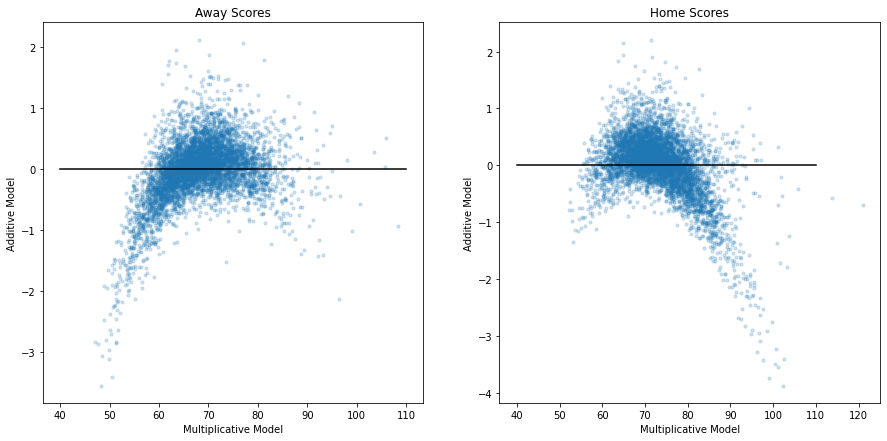

In [92]:
fig, ax = plt.subplots(ncols=2,figsize=(15,7))

ax[0].scatter(games_model_m['away_score_mod'],
              games_model_a['away_score_mod']-games_model_m['away_score_mod'],
              alpha=0.2,
              s=10)

#ax[0].plot([40,110],[40,110], color='black')
ax[0].plot([40,110],[0,0], color='black')
ax[0].set_title('Away Scores')
ax[0].set_xlabel('Multiplicative Model')
ax[0].set_ylabel('Additive Model')

ax[1].scatter(games_model_m['home_score_mod'],
              games_model_a['home_score_mod']-games_model_m['home_score_mod'],
              alpha=0.2,
              s=10)

#ax[1].plot([40,110],[40,110], color='black')
ax[1].plot([40,110],[0,0], color='black')
ax[1].set_title('Home Scores')
ax[1].set_xlabel('Multiplicative Model')
ax[1].set_ylabel('Additive Model')

In [87]:
np.cov(games_model_m['away_score']-games_model_m['away_score_mod'],
       games_model_m['home_score']-games_model_m['home_score_mod'])

array([[79.6378224 , 26.79194751],
       [26.79194751, 81.60957435]])

In [88]:
np.cov(games_model_a['away_score']-games_model_a['away_score_mod'],
       games_model_a['home_score']-games_model_a['home_score_mod'])

array([[79.38631478, 26.93314407],
       [26.93314407, 82.15498368]])

Text(0, 0.5, 'Actual Points')

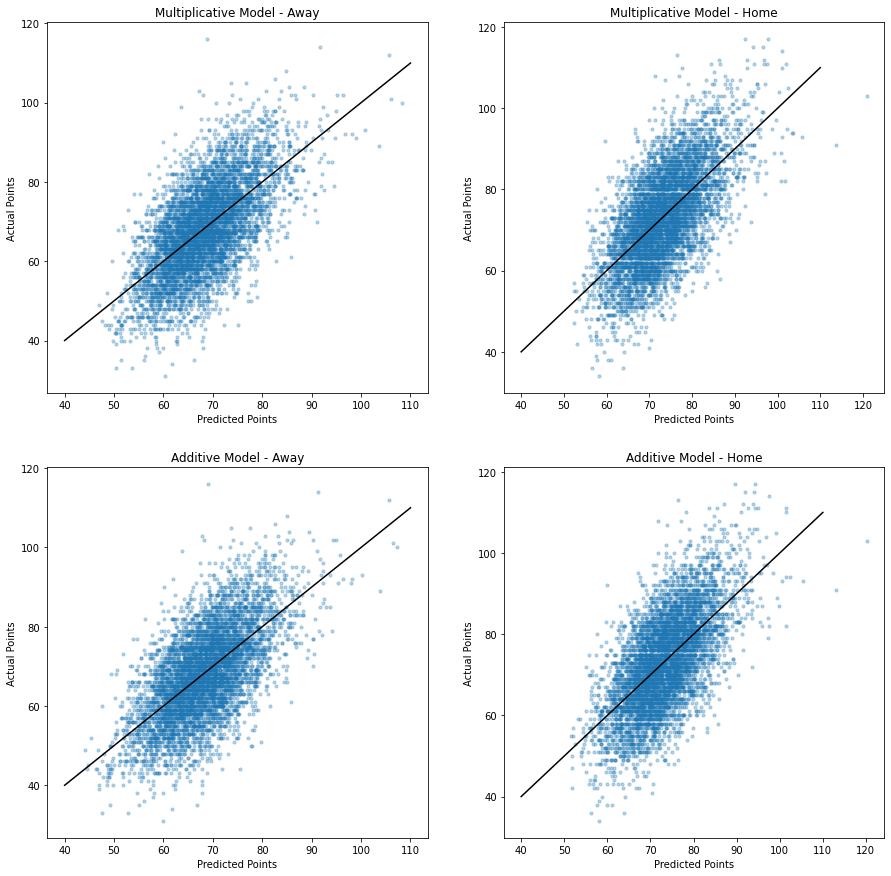

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

# Multiplicative Away
ax[0,0].scatter(games_model_m['away_score_mod'],
                games_model_m['away_score'],
                alpha=0.3,
                s=10)

ax[0,0].plot([40,110],[40,110], color='black')
ax[0,0].set_title('Multiplicative Model - Away')
ax[0,0].set_xlabel('Predicted Points')
ax[0,0].set_ylabel('Actual Points')

# Multiplicative Home
ax[0,1].scatter(games_model_m['home_score_mod'],
                games_model_m['home_score'],
                alpha=0.3,
                s=10)

ax[0,1].plot([40,110],[40,110], color='black')
ax[0,1].set_title('Multiplicative Model - Home')
ax[0,1].set_xlabel('Predicted Points')
ax[0,1].set_ylabel('Actual Points')

# Additive Away
ax[1,0].scatter(games_model_a['away_score_mod'],
                games_model_a['away_score'],
                alpha=0.3,
                s=10)

ax[1,0].plot([40,110],[40,110], color='black')
ax[1,0].set_title('Additive Model - Away')
ax[1,0].set_xlabel('Predicted Points')
ax[1,0].set_ylabel('Actual Points')

# Additive Home
ax[1,1].scatter(games_model_a['home_score_mod'],
                games_model_a['home_score'],
                alpha=0.3,
                s=10)

ax[1,1].plot([40,110],[40,110], color='black')
ax[1,1].set_title('Additive Model - Home')
ax[1,1].set_xlabel('Predicted Points')
ax[1,1].set_ylabel('Actual Points')

Text(0, 0.5, 'Actual Points - Predicted Points')

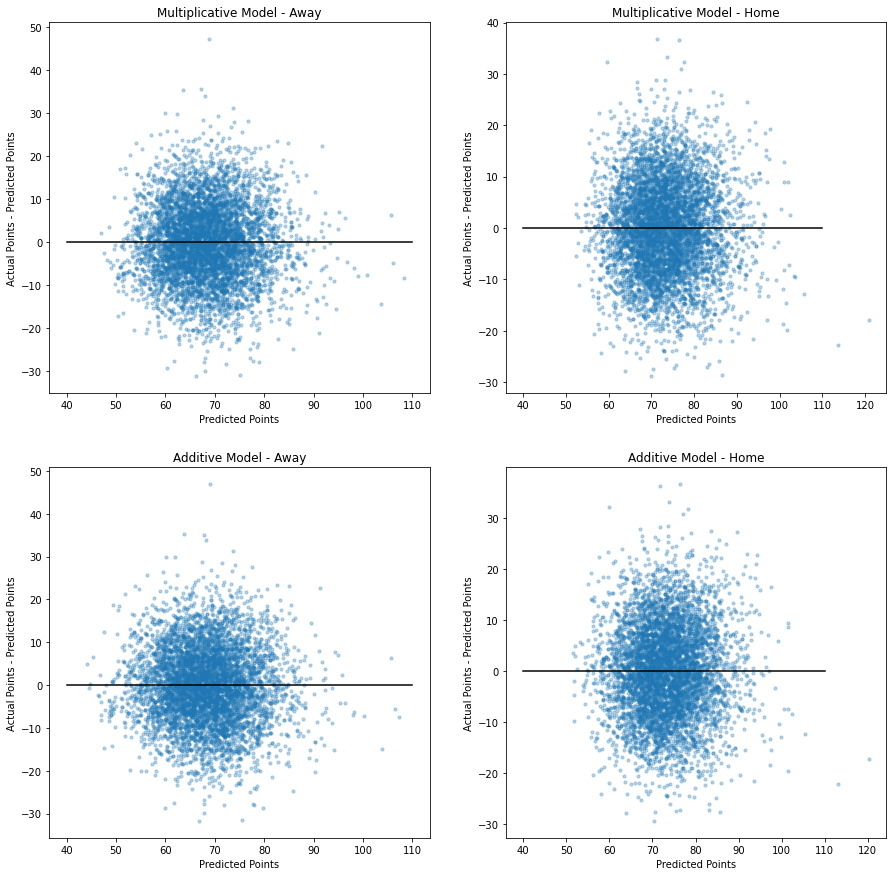

In [86]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

# Multiplicative Away
ax[0,0].scatter(games_model_m['away_score_mod'],
                games_model_m['away_score']-games_model_m['away_score_mod'],
                alpha=0.3,
                s=10)

ax[0,0].plot([40,110],[0,0], color='black')
ax[0,0].set_title('Multiplicative Model - Away')
ax[0,0].set_xlabel('Predicted Points')
ax[0,0].set_ylabel('Actual Points - Predicted Points')

# Multiplicative Home
ax[0,1].scatter(games_model_m['home_score_mod'],
                games_model_m['home_score']-games_model_m['home_score_mod'],
                alpha=0.3,
                s=10)

ax[0,1].plot([40,110],[0,0], color='black')
ax[0,1].set_title('Multiplicative Model - Home')
ax[0,1].set_xlabel('Predicted Points')
ax[0,1].set_ylabel('Actual Points - Predicted Points')

# Additive Away
ax[1,0].scatter(games_model_a['away_score_mod'],
                games_model_a['away_score']-games_model_a['away_score_mod'],
                alpha=0.3,
                s=10)

ax[1,0].plot([40,110],[0,0], color='black')
ax[1,0].set_title('Additive Model - Away')
ax[1,0].set_xlabel('Predicted Points')
ax[1,0].set_ylabel('Actual Points - Predicted Points')

# Additive Home
ax[1,1].scatter(games_model_a['home_score_mod'],
                games_model_a['home_score']-games_model_a['home_score_mod'],
                alpha=0.3,
                s=10)

ax[1,1].plot([40,110],[0,0], color='black')
ax[1,1].set_title('Additive Model - Home')
ax[1,1].set_xlabel('Predicted Points')
ax[1,1].set_ylabel('Actual Points - Predicted Points')

In [111]:
print(np.mean(games_model_m.loc[games_model_a['away_score_mod']<53,'away_score']))
print(np.mean(games_model_m.loc[games_model_a['away_score_mod']<53,'away_score_mod']))

print(np.mean(games_model_a.loc[games_model_a['away_score_mod']<53,'away_score']))
print(np.mean(games_model_a.loc[games_model_a['away_score_mod']<53,'away_score_mod']))

print(np.mean(games_model_m.loc[games_model_a['away_score_mod']>95,'home_score']))
print(np.mean(games_model_m.loc[games_model_a['away_score_mod']>95,'home_score_mod']))

print(np.mean(games_model_a.loc[games_model_a['away_score_mod']>95,'home_score']))
print(np.mean(games_model_a.loc[games_model_a['away_score_mod']>95,'home_score_mod']))

50.0
52.17876842781834
50.0
50.3922729049366
96.81818181818181
98.026429022819
96.81818181818181
98.01048992088069


In [25]:
par_dict.to_excel('NCAA2223_ranking.xlsx', sheet_name='Add')

In [18]:
par_dict[par_dict['team'].isin(['Arizona',
                                'Arizona State',
                                'California',
                                'Colorado',
                                'Oregon',
                                'Oregon State',
                                'Stanford',
                                'UCLA',
                                'USC',
                                'Utah',
                                'Washington',
                                'Washington State'])].sort_values(by='ratio', ascending=False)

,team,offense,defense,ratio
1,UCLA,9.221237,6.840711,1.347994
8,Arizona,10.512694,8.277386,1.270050
32,USC,9.194472,7.763812,1.184273
38,Oregon,9.059154,7.731536,1.171715
46,Washington State,8.604497,7.438482,1.156754
49,Colorado,8.871534,7.689645,1.153699
50,Utah,8.627126,7.504361,1.149615
57,Arizona State,8.744522,7.688962,1.137283
73,Stanford,8.885689,7.952543,1.117339
89,Washington,8.649509,8.039013,1.075942


In [189]:
h_adv

0.02326700924681039

In [41]:
team_name = 'Colorado'
games_model[(games_model['home_team']==team_name)|(games_model['away_team']==team_name)][['away_team',
                                                                                          'away_score_mod',
                                                                                          'away_score',
                                                                                          'home_score',
                                                                                          'home_score_mod',
                                                                                          'home_team',
                                                                                          'ot',
                                                                                          'neutral']]

,away_team,away_score_mod,away_score,home_score,home_score_mod,home_team,ot,neutral
100,UC Riverside,63.522938,66,82,76.418493,Colorado,0.0,0
233,Colorado,69.556548,74,83,59.647086,Grambling,0.0,0
291,Colorado,57.735357,78,66,70.239538,Tennessee,0.0,0
453,Colorado,77.304071,63,66,64.537497,UMass,0.0,1
501,Colorado,67.877395,103,75,69.734617,Texas A&M,0.0,1
666,Colorado,65.881788,55,68,67.121546,Boise State,0.0,1
1051,Yale,65.056091,62,65,69.933507,Colorado,0.0,0
1210,Arizona State,65.579366,60,59,70.359494,Colorado,0.0,0
1356,Colorado,70.265433,63,73,68.141484,Washington,0.0,0
1482,Colorado State,66.186521,65,93,75.323667,Colorado,0.0,0


8.923259190559419


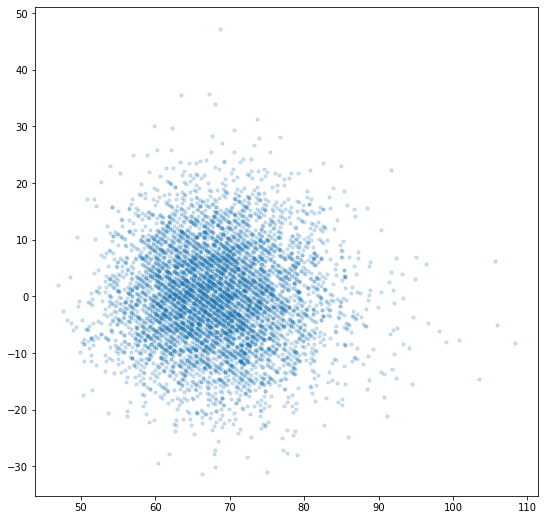

In [24]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games_model['away_score_mod'],
           games_model['away_score']-games_model['away_score_mod'],
           alpha=0.2,
           s=10)

print(np.std(games_model['away_score']-games_model['away_score_mod']))

9.032983966558842


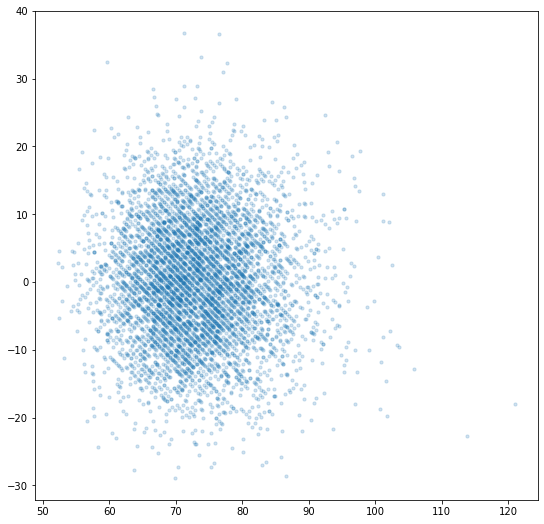

In [25]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games_model['home_score_mod'],
           games_model['home_score']-games_model['home_score_mod'],
           alpha=0.2,
           s=10)

print(np.std(games_model['home_score']-games_model['home_score_mod']))

In [151]:
rho = 0.0
matro = np.array([[np.sum(games_model.loc[games_model['home_id']==k,'home_score_mod']**2)/par_dict.loc[k,'offense']**2 + \
          np.sum(games_model.loc[games_model['away_id']==k,'away_score_mod']**2)/par_dict.loc[k,'offense']**2 if k==l \
          else -rho*(np.sum(games_model.loc[(games_model['home_id']==k)&(games_model['away_id']==l),'away_score_mod'] * \
                            games_model.loc[(games_model['home_id']==k)&(games_model['away_id']==l),'home_score_mod']) / \
                 par_dict.loc[k,'offense'] / par_dict.loc[l,'offense'] + \
          np.sum(games_model.loc[(games_model['home_id']==l)&(games_model['away_id']==k),'away_score_mod'] * \
                 games_model.loc[(games_model['home_id']==l)&(games_model['away_id']==k),'home_score_mod']) / \
                 par_dict.loc[k,'offense'] / par_dict.loc[l,'offense']) \
          for l in np.sort(games_model['home_id'].unique())] \
         for k in np.sort(games_model['home_id'].unique())])

b = np.array([np.sum(games_model.loc[games_model['home_id']==k,'home_score_mod'] * \
                     (games_model.loc[games_model['home_id']==k,'home_score'] - \
                      rho*games_model.loc[games_model['home_id']==k,'away_score'])) / \
                    par_dict.loc[k,'offense'] + \
              np.sum(games_model.loc[games_model['away_id']==k,'away_score_mod'] * \
                     (games_model.loc[games_model['away_id']==k,'away_score'] - \
                      rho*games_model.loc[games_model['away_id']==k,'home_score'])) / \
                    par_dict.loc[k,'offense'] for k in np.sort(games_model['home_id'].unique())])

In [152]:
matro

array([[9514.88760135,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ],
       [  -0.        , 9659.2394066 ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
          -0.        ,   -0.        ,   -0.        ,   -0.        ,
         

In [165]:
b

array([104695.95828456, 105043.8972307 ,  99723.25761119,  97913.49271773,
       100583.54579729,  99741.88169212, 102114.7974064 , 102499.2508281 ,
        97441.75241284, 105554.05657227,  97875.35603925, 102007.91449346,
       101223.96290518, 104288.90986897, 103752.05721608,  96760.20104159,
       103381.93944693, 102905.10970641, 101864.51639535, 103304.24894563,
       104374.16762983,  98272.89455031, 102292.29821617, 100727.91250232,
       100227.20576695, 107322.21411275, 100353.4064606 ,  99604.63738616,
       103763.34931135,  99631.62590085])

In [166]:
off_cov = np.linalg.solve(matro,b)
off_cov

array([11.00338361, 10.8749657 , 10.57262159, 10.32856061, 10.44978613,
       10.36902242, 10.49704544, 10.74297887, 10.28105319, 10.99672299,
       10.28868653, 10.87350829, 10.49267329, 10.80379068, 10.81578492,
       10.15938951, 10.86184239, 10.68114486, 10.53958466, 10.70924076,
       10.85081323, 10.37617262, 10.64692684, 10.52982798, 10.54321604,
       11.16601641, 10.45949369, 10.49999972, 10.83794938, 10.55317364])

In [167]:
np.dot(matro, off_cov)

array([104695.95828456, 105043.8972307 ,  99723.25761119,  97913.49271773,
       100583.54579729,  99741.88169212, 102114.7974064 , 102499.2508281 ,
        97441.75241284, 105554.05657227,  97875.35603925, 102007.91449346,
       101223.96290518, 104288.90986897, 103752.05721608,  96760.20104159,
       103381.93944693, 102905.10970641, 101864.51639535, 103304.24894563,
       104374.16762983,  98272.89455031, 102292.29821617, 100727.91250232,
       100227.20576695, 107322.21411275, 100353.4064606 ,  99604.63738616,
       103763.34931135,  99631.62590085])

[[130.60643205  40.56314336]
 [ 40.56314336 136.9652647 ]]


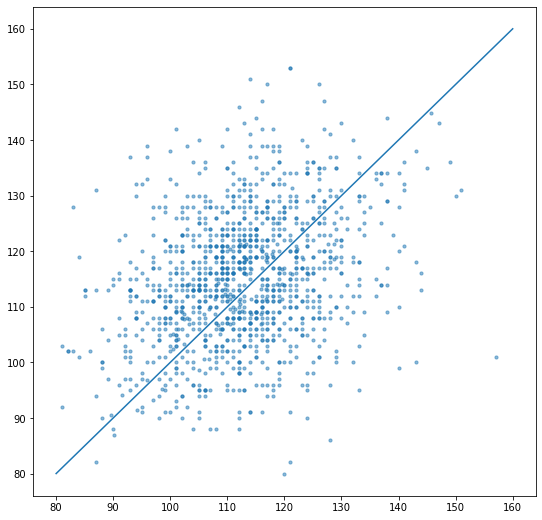

In [85]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games['away_score'] / (1.0 + games['ot']*5/48),
           games['home_score'] / (1.0 + games['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([80,160],[80,160])

print(np.cov(games['away_score'] / (1.0 + games['ot']*5/48),
             games['home_score'] / (1.0 + games['ot']*5/48)))

[[18.3847451   3.97826657]
 [ 3.97826657 19.23782058]]


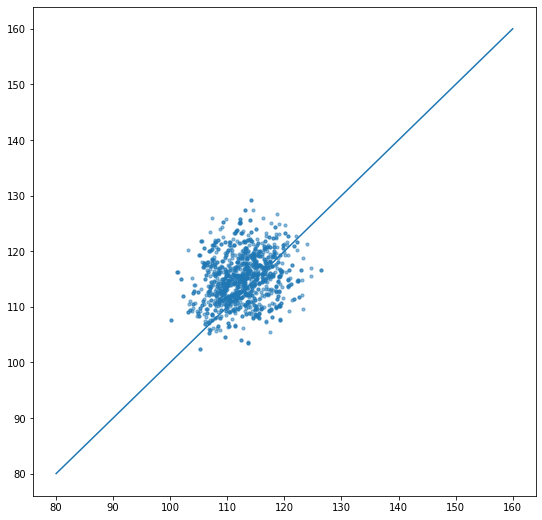

In [84]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games_model['away_score'] / (1.0 + games_model['ot']*5/48),
           games_model['home_score'] / (1.0 + games_model['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([80,160],[80,160])

print(np.cov(games_model['away_score'] / (1.0 + games_model['ot']*5/48),
             games_model['home_score'] / (1.0 + games_model['ot']*5/48)))

[[112.43830995  36.74263359]
 [ 36.74263359 117.53824947]]


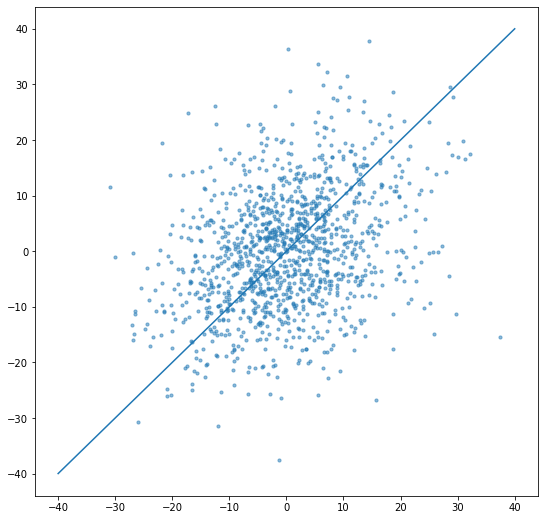

In [40]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games['away_score'] / (1.0 + games['ot']*5/48)-games_model['away_score_mod'] / (1.0 + games_model['ot']*5/48),
           games['home_score'] / (1.0 + games['ot']*5/48)-games_model['home_score_mod'] / (1.0 + games_model['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([-40,40],[-40,40])

print(np.cov(games['away_score']/(1.0 + games['ot']*5/48)-games_model['away_score_mod'] / (1.0 + games_model['ot']*5/48),
             games['home_score']/(1.0 + games['ot']*5/48)-games_model['home_score_mod'] / (1.0 + games_model['ot']*5/48)))

In [104]:
par_dict_a, h_adv_a, games_model_a = fit_parameters(games, model_type='add', no_neutral=False, delta_thresh=1e-3)

2.0562674927624376
1.8572456504289032
1.7708650386156333
1.7240901009070577
1.698136243856273
1.683480441131665
1.675079897527932
1.6702014654581359
1.6673345955245356
1.6656308260328985
1.6646070716544057
1.663985050864099
1.66360278351801
1.663365070271779
1.6632154349863655
1.6631200583122303
1.6630584920490998
1.663018247106003
1.6629916138949226
1.6629737795525097


In [105]:
h_adv_a

1.6629737795525097

In [106]:
par_dict_a['diff'] = par_dict_a['offense'] - par_dict_a['defense']

In [111]:
par_dict_a.sort_values(by='diff', ascending=False)[0:25]

,team,offense,defense,diff
3,Alabama,49.983392,28.908724,21.074667
113,Houston,40.027223,19.137130,20.890092
315,UCLA,41.874703,21.690987,20.183715
292,Tennessee,39.331451,20.038877,19.292574
59,Connecticut,45.134535,26.609294,18.525241
295,Texas,45.344892,27.080245,18.264647
102,Gonzaga,52.280570,34.252389,18.028181
10,Arizona,51.867574,34.379029,17.488545
131,Kansas,44.417461,27.254506,17.162955
235,Purdue,41.359610,24.450954,16.908656


In [108]:
games_model_a[['away_team','away_score_mod','away_score','home_score','home_score_mod','home_team','ot']]

,away_team,away_score_mod,away_score,home_score,home_score_mod,home_team,ot
0,UNC Wilmington,60.572300,56,69,75.839054,North Carolina,0.0
1,North Florida,70.134257,63,104,97.242867,Gonzaga,0.0
2,Northern Colorado,55.838055,36,83,84.133936,Houston,0.0
3,Howard,63.181202,63,95,82.943995,Kentucky,0.0
4,Mississippi Valley State,54.419376,53,117,89.815196,Baylor,0.0
...,...,...,...,...,...,...,...
5597,Yale,70.651878,65,74,68.444761,Princeton,0.0
5598,Texas A&M,69.514535,63,82,78.243530,Alabama,0.0
5599,Dayton,61.303591,56,68,62.598965,VCU,0.0
5600,Memphis,65.430455,75,65,73.747349,Houston,0.0


In [196]:
team_name = 'Purdue'
games_model[(games_model['home_team']==team_name)|(games_model['away_team']==team_name)]\
[['away_team','away_score_mod','away_score','home_score','home_score_mod','home_team','ot','neutral']]

,away_team,away_score_mod,away_score,home_score,home_score_mod,home_team,ot,neutral
127,Milwaukee,60.357758,53,84,86.288669,Purdue,0.0,0
215,Austin Peay,51.335803,44,63,81.427666,Purdue,0.0,0
405,Marquette,67.708603,70,75,73.791480,Purdue,0.0,0
853,Purdue,72.371273,80,68,68.884794,West Virginia,0.0,1
871,Purdue,75.597927,84,66,74.781669,Gonzaga,0.0,1
1013,Duke,63.539482,56,75,67.238018,Purdue,0.0,1
1118,Purdue,78.979208,79,69,62.348496,Florida State,0.0,0
1363,Minnesota,54.963662,70,89,76.967941,Purdue,0.0,0
1428,Hofstra,60.688038,66,85,76.138403,Purdue,0.0,0
1519,Purdue,78.398989,65,62,69.229060,Nebraska,1.0,0


[[112.39903509  36.70225334]
 [ 36.70225334 117.50376283]]


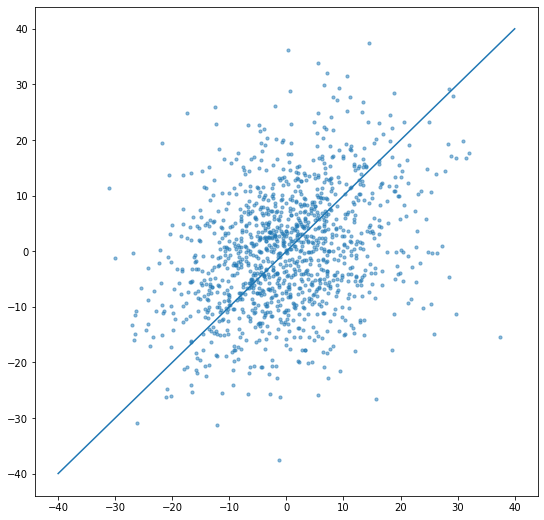

In [41]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games['away_score'] / (1.0 + games['ot']*5/48)-games_model_a['away_score'] / (1.0 + games_model_a['ot']*5/48),
           games['home_score'] / (1.0 + games['ot']*5/48)-games_model_a['home_score'] / (1.0 + games_model_a['ot']*5/48),
           alpha=0.5,
           s=10)

ax.plot([-40,40],[-40,40])

print(np.cov(games['away_score']/(1.0 + games['ot']*5/48)-games_model_a['away_score'] / (1.0 + games_model_a['ot']*5/48),
             games['home_score']/(1.0 + games['ot']*5/48)-games_model_a['home_score'] / (1.0 + games_model_a['ot']*5/48)))

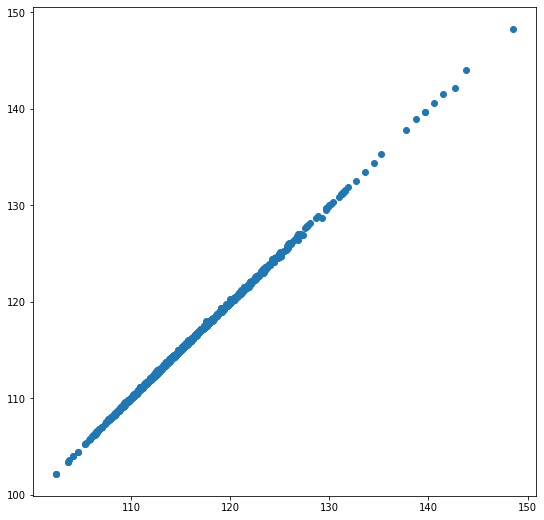

In [28]:
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(games_model['home_score_mod'],games_model_a['home_score_mod'])